### project3_2_eda_modeling.ipynb

This is the notebook where I did my data exploration and cleaning, and ran my first two very simple models, Naive Bayesian and Logistic Regression.

Import libraries:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB





Read in the data, drop the extra column:

In [2]:
df = pd.read_csv('./data/redditcomments.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  19999 non-null  object
 1   date     20000 non-null  int64 
 2   types    20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Did a little digging and found the null value was in comment #7581, dropped it:

In [3]:
df['comment'][7581]

nan

In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  19999 non-null  object
 1   date     19999 non-null  int64 
 2   types    19999 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


What kind of comments do I have? First cut, look at the length:

In [5]:
df['char_length'] = [len(comment) for comment in list(df['comment'])]
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      19999 non-null  object
 1   date         19999 non-null  int64 
 2   types        19999 non-null  object
 3   char_length  19999 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 781.2+ KB


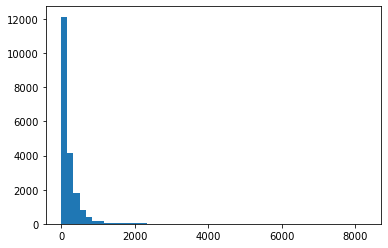

In [6]:
plt.hist(df['char_length'],50);

In [7]:
df['char_length'].min()

1

In [8]:
df['char_length'].max()

8288

In [9]:
df[df['char_length'] == df['char_length'].max()]['comment']


16246     The question of whether we are alone in space...
Name: comment, dtype: object

In [10]:
df['comment'][16246][:1000]

' The question of whether we are alone in space has always sparked the imagination of mankind. But what should we do if we really encounter some form of extraterrestrial intelligence? In his book "You Are There - How First Contact with Aliens Could Change Our Society" (Complete Media 2020), the sociologist Michael Schetsche and his co-author Andreas Anton outline possible scenarios. With his thought experiments, Schetsche wants to establish exosociology - a discipline that deals with the consequences of a human-alien encounter. \n\n&amp;#x200B;\n\n \n\n**Schetch:** Intelligence is relative. We\'ve been arguing for 60 years whether dolphins are intelligent or not. If we receive a signal of extraterrestrial origin, if we find the remains of an extraterrestrial space probe or if a foreign object enters our solar system, no one would doubt that they are intelligent beings simply because of the necessary technical skills. However, if one day in the distant future, most likely millennia in t

In [11]:
df.groupby('types')['char_length'].min()

types
fantasy    1
scifi      1
Name: char_length, dtype: int64

In [12]:
df.groupby('types')['char_length'].max()

types
fantasy    6301
scifi      8288
Name: char_length, dtype: int64

In [13]:
df[df['char_length']==1]['comment'].head()

377     😭
1835    🌻
2130    ?
6226    👍
6256    🙌
Name: comment, dtype: object

In [14]:
df[df['char_length']==2]['comment'].head()

1163    Aa
5240    No
5766    :c
5861    No
7583    🙌🏻
Name: comment, dtype: object

In [15]:
df[df['char_length']==3]['comment'].head()

465     Bl?
2462    Dad
3463    Lol
3680    WoW
5275    yes
Name: comment, dtype: object

So it looks like really short ones are useless in terms of information. I would love to be more restrictive, but I don't want to lose half my data either, so I'm just throwing out comments shorter than 10 characters.

Also there are a few really long ones that are not conversational -- they read like book reports. Not so helpful for my problem statement. So I'm throwing out any comments 1000 characters or longer.

In [16]:
df[(df['char_length']>=10) & (df['char_length']<1000)]['types'].value_counts(normalize=True)

fantasy    0.503787
scifi      0.496213
Name: types, dtype: float64

In [17]:
df[(df['char_length']>=10) & (df['char_length']<1000)]['types'].value_counts(normalize=False)

fantasy    9444
scifi      9302
Name: types, dtype: int64

In [18]:
df = df[(df['char_length']>=10) & (df['char_length']<1000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18746 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      18746 non-null  object
 1   date         18746 non-null  int64 
 2   types        18746 non-null  object
 3   char_length  18746 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 732.3+ KB


Good, I still have a fair amount of data. 

Also did some digging to establish what moderator remove messages look like; they appear to always contain the word "removed". I may remove a few good comments this way, but I am simply dumping any comments with that word.

In [20]:
comments = list(df['comment'])
flagged = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
for n, f in enumerate(flagged):
    if f==1: print(comments[n])


Hi there, unfortunately this post has been removed under our Self Promo guidelines. Please consult our rules in the sidebar and feel free to [modmail](https://www.reddit.com/message/compose?to=/r/Fantasy) us if you have any questions.
Hi there! This post has been removed per our Self Promotion and Writing Discussion policies. Please take some time to review the subreddit sidebar for additional information, and feel free to reach out via [modmail](https://www.reddit.com/message/compose?to=%2Fr%2FFantasy) with any follow-up questions. Thank you!
Hi there! This post has been removed as it is not a good fit for this subreddit. We attempt to ensure all posts are dealing directly with published fantasy media such as books, films, graphic novels, etc. Consider a community like r/FindAReddit to assist with finding a more appropriate place to post about this topic. Please take some time to review the subreddit sidebar for additional information, and feel free to reach out via [modmail](https://

In [28]:
comments = list(df['comment'])
df['flagged'] = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
df = df[df['flagged']==0]

Set my X (comment text) and y (which subreddit):

In [29]:
X = df['comment']
y = df['types']


I started with just Count Vectorization. Later I went back and tried Tfid instead, but it didn't really help:

In [30]:
cvec = CountVectorizer(stop_words='english')

In [31]:
cvec.fit(X)
X_cv = cvec.transform(X)

EDA: What are the common words?

<AxesSubplot:>

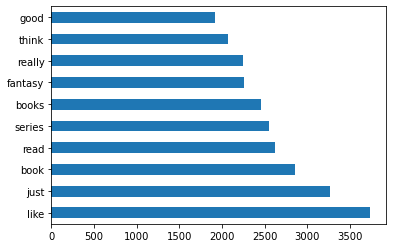

In [32]:
words = pd.DataFrame(X_cv.todense(),columns= cvec.get_feature_names())

# plot top occuring words
words.sum().sort_values(ascending = False).head(10).plot(kind='barh')

I am interested in discerning which words (hopefully referring to specific series or characters) are particularly unique to each genre, fantasy vs. scifi. So I'm going to take some time to ind words that are frequent in both, and remove them:

In [33]:
def plot_common_words(df,subreddit,stop_words):
    
    # Makes a plot of the common words in a given subreddit:
    cv0 = CountVectorizer(stop_words=stop_words)
    X0 = df[df['types']==subreddit]['comment']
    cv0.fit(X0)
    X0_cv = cv0.transform(X0)
    words = pd.DataFrame(X0_cv.todense(),columns= cv0.get_feature_names())
    words.sum().sort_values(ascending = False).head(20).plot(kind='barh');
    plt.title(subreddit);

In [34]:
def compare_sets(df,stop_words,plot=1,num_header=10):
    
    # Compares the top 10/20/num_header words in the two subreddits, and
    # makes a list of the words that are in the top "num_header" list of BOTH (the overlap)
    #
    # if plot = 1, a plot of the most frequent words in each is generated.
    #
    # stop_words is an input. This will be run iteratively, adding words to the stop_words
    # list each time.
    #
    if plot==1: fig, axs = plt.subplots(2,1);
    subreddits = ['fantasy', 'scifi']
    for n,subreddit in enumerate(subreddits):
    #loop over the two subreddits:
    
        # count vectorize using the input stop_words list:
        cv0 = CountVectorizer(stop_words=stop_words)
        # grab just the comments from one subreddit:
        X0 = df[df['types']==subreddit]['comment']
        cv0.fit(X0)
        X0_cv = cv0.transform(X0)
        
        # make a list of most frequent words, and if plot == 1, make the plot:
        words = pd.DataFrame(X0_cv.todense(),columns= cv0.get_feature_names())
        chk = words.sum().sort_values(ascending = False).head(num_header)
        if plot==1: chk.plot(kind='barh',ax=axs[n],legend=False,ylabel=subreddit);
        
        #check for overlap:
        if n==0:
            first_set = list(chk.index)
        else:
            new_set = list(chk.index)
            overlap = [word for word in new_set if word in first_set]
            
    print('Words in both sets:')
    print(overlap)
    return overlap

In [35]:
# initialize CountVectorizer once just to grab the standard "english" stop_words list
cv1 = CountVectorizer(stop_words='english')
stop_eng = list(cv1.get_stop_words())


Words in both sets:
['like', 'just', 'really', 'think', 'don']


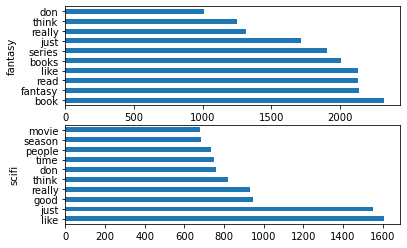

In [36]:
# do an initial comparison:
overlap = compare_sets(df,stop_eng,plot=1,num_header=10)

In [37]:
overlap = compare_sets(df,stop_eng,plot=0,num_header=10)

Words in both sets:
['like', 'just', 'really', 'think', 'don']


In [38]:
# make my initial stop_words list, which is the "english" list plus the actual subreddit names:
stop_eng = list(cv1.get_stop_words())
stops = stop_eng.copy()
stops += ['fantasy', 'scifi', 'sci', 'fi']
stops

['thick',
 'beyond',
 'six',
 'hereafter',
 'both',
 'her',
 'am',
 'forty',
 'very',
 'its',
 'above',
 'ours',
 'who',
 'someone',
 'might',
 'whenever',
 'per',
 'un',
 'may',
 'cannot',
 'formerly',
 'before',
 'up',
 'of',
 'amongst',
 'couldnt',
 'more',
 'four',
 'it',
 'thereupon',
 'there',
 'again',
 'him',
 'beside',
 'they',
 'less',
 'us',
 'hasnt',
 'in',
 'while',
 'one',
 'seeming',
 'had',
 'several',
 'thereafter',
 'since',
 'ten',
 'for',
 'too',
 'been',
 'de',
 'etc',
 'herself',
 'wherein',
 'herein',
 'during',
 'such',
 'noone',
 'yours',
 'serious',
 'whether',
 'enough',
 'whoever',
 'cant',
 'must',
 'eg',
 'otherwise',
 'itself',
 'get',
 'them',
 'why',
 'few',
 'nobody',
 'rather',
 'between',
 'ourselves',
 'fill',
 'below',
 'are',
 'indeed',
 'mine',
 'still',
 'perhaps',
 'thence',
 'most',
 'others',
 'no',
 'go',
 'then',
 'inc',
 'have',
 'hers',
 'twenty',
 'this',
 'full',
 'me',
 'either',
 'side',
 'onto',
 'five',
 'latterly',
 'con',
 'except

iteration #0:
Words in both sets:
['like', 'just', 'good', 'really', 'think', 'don', 'time', 'people', 'com', 'series', 'https', 'gt', 'book', 've']
iteration #1:
Words in both sets:
['great', 'story', 'www', 'read', 'way', 'know', 'books', 'character', 'got', 'lot']
iteration #2:
Words in both sets:
['didn', 'make', 'going', 'pretty', 'love', 'say', 'actually', 'reddit', 'll', 'things']
iteration #3:
Words in both sets:
['did', 'better', 'years', 'world', 'thing', 'want', 'characters']
iteration #4:
Words in both sets:
['sure', 'new', 'right', 'doesn']
iteration #5:
Words in both sets:
['best', 'end', 'point']
iteration #6:
Words in both sets:
['does', 'different']
iteration #7:
Words in both sets:
['maybe']
iteration #8:
Words in both sets:
[]
iteration #9:
Words in both sets:
[]
Words in both sets:
[]


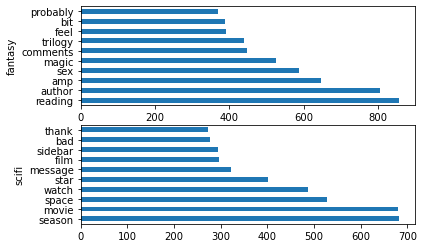

In [39]:
# Iterate 10 times to try to improve the stop list. 
# After each comparison, and overlap in the two "most frequent" lists will be added to stop_words

for i in range(10):
    print(f'iteration #{i}:')
    overlap = compare_sets(df,stops,plot=0,num_header=20)
    stops += overlap

# After the 10 iterations, plot the resulting non-overlapping list of most frequent words:
overlap = compare_sets(df,stops,plot=1,num_header=10)



In [40]:
stops

['thick',
 'beyond',
 'six',
 'hereafter',
 'both',
 'her',
 'am',
 'forty',
 'very',
 'its',
 'above',
 'ours',
 'who',
 'someone',
 'might',
 'whenever',
 'per',
 'un',
 'may',
 'cannot',
 'formerly',
 'before',
 'up',
 'of',
 'amongst',
 'couldnt',
 'more',
 'four',
 'it',
 'thereupon',
 'there',
 'again',
 'him',
 'beside',
 'they',
 'less',
 'us',
 'hasnt',
 'in',
 'while',
 'one',
 'seeming',
 'had',
 'several',
 'thereafter',
 'since',
 'ten',
 'for',
 'too',
 'been',
 'de',
 'etc',
 'herself',
 'wherein',
 'herein',
 'during',
 'such',
 'noone',
 'yours',
 'serious',
 'whether',
 'enough',
 'whoever',
 'cant',
 'must',
 'eg',
 'otherwise',
 'itself',
 'get',
 'them',
 'why',
 'few',
 'nobody',
 'rather',
 'between',
 'ourselves',
 'fill',
 'below',
 'are',
 'indeed',
 'mine',
 'still',
 'perhaps',
 'thence',
 'most',
 'others',
 'no',
 'go',
 'then',
 'inc',
 'have',
 'hers',
 'twenty',
 'this',
 'full',
 'me',
 'either',
 'side',
 'onto',
 'five',
 'latterly',
 'con',
 'except

Save the stopwords to a file:

In [41]:
stopwords = pd.DataFrame(stops)
stopwords.to_csv('./data/stopwords.csv')

### Baseline:

In [43]:
# The "NULL" model would just guess all the comments came from one subreddit, so the baseline 
# accuracy is the proportion of whichever subreddit is dominant.

baseline = y.value_counts(normalize=True).max()
baseline

0.5018337101230846

### First try models:

In [44]:
# test train split -- my data is pretty close to a 50/50 balance, but I will stratify just to be safe:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)

# Count Vectorize with the NEW stop_words list:
cv = CountVectorizer(stop_words=stops)
cv.fit(X_train,y_train)
X_train = cv.transform(X_train)
X_test  = cv.transform(X_test)


#### First model: Naive Bayesian, default parameters:

In [45]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb_train = nb.score(X_train,y_train)
nb_test  = nb.score(X_test,y_test)
print(f'Train: {nb_train}, Test: {nb_test}')

Train: 0.8294480171489818, Test: 0.7791842475386779


#### Second model: Logistic Regression, default parameters:

In [46]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')

Train: 0.9407154340836013, Test: 0.814948764315853


This is CLEARLY overfit. I'm going to do a bunch of other models and some tuning.

Note from "future me": Nothing else is going to turn out to beat the "test" score of this default logistic regression.

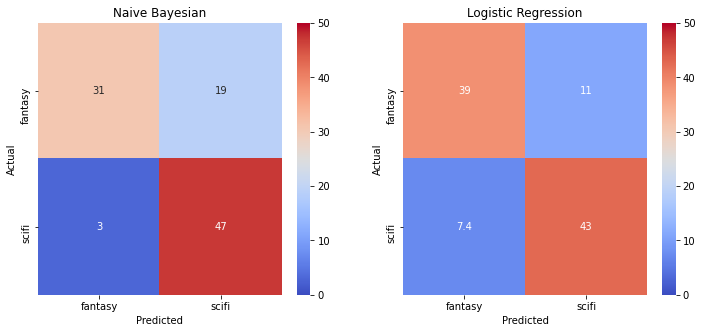

In [47]:
# Compare the confusion matrices:


subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(12,5));

# Naive Bayesian:
ax = fig.add_subplot(121);
# get predictions and probabilities for the model (will be stored later)
preds_nb = nb.predict(X_test)
probs_nb = nb.predict_proba(X_test)
# get and plot confustion matrix:
cm = confusion_matrix(y_test, preds_nb)
cm = cm*100/sum(sum(cm)); # convert to percent of total comments
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Naive Bayesian');

# Logistic Regression:
ax = fig.add_subplot(122);
# get predictions and probabilities for the model (will be stored later)
preds_lr = lr.predict(X_test)
probs_lr = lr.predict_proba(X_test)
# get and plot confustion matrix:
cm = confusion_matrix(y_test, preds_lr)
cm = cm*100/sum(sum(cm)); # convert to percent of total comments
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression');


# Notes: I wanted to have proper labels, and I wanted to control the range and palette of
# the colorbar. That's why I ended up with heatmaps - maybe I could have accomplished the 
# same thing with ConfusionMatrixDisplay, but it wasn't working for me.

# Also, because the dataset is so large, the annotations were showing up in scientific notation.
# To improve readability and interpretability, I normalized them, so the annotations are now the 
# percent of the total number of comments. A perfect model's cm would therefore be [[50, 0], [0,50]].

# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

Note that the confusion marices have been converted to percentages.

So the Naive Bayesian is much better at sensitivity to Scifi, but has a tendency to misclassify Fantasy as Scifi. 

The Logistic Regression on the other hand has about 80% sensitivity to both categories.

Since there is no particular reason to prioritize scifi sensitivity over fantasy, the logistic regression is a better choice.

In [48]:
# Make a dataframe of the various model scores:

scores = [
    {
    'model': 'NULL',
    'train': y_train.value_counts(normalize=True).max(),
    'test' : y_test.value_counts(normalize=True).max()
    },

    {
    'model': 'NBayesian',
    'train': nb.score(X_train,y_train),
    'test' : nb.score(X_test, y_test)
    },

    {
    'model': 'LogReg',
    'train': lr.score(X_train,y_train),
    'test' : lr.score(X_test, y_test)
    }
]
scores_df = pd.DataFrame(scores)


Let's try to improve the simple logistic regression model with a pipeline GridSearchCV:

In [49]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lg', LogisticRegression(max_iter=10_000))
])
# Explore the effects of how many features are allowed 
# and whether the count vectorizer can also include word pairs:
pipe_params = {
    'cvec__max_features':[1_000, 2_000, 5_000],
    'cvec__ngram_range':[(1,1), (1,2)]
}

# run the search, with verbose=2 so I can see that something is happening:
lr_pipe = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose = 2)
lr_pipe.fit(X,y)
lr_pipe.best_score_



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 1), total=   1.7s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 1) ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 1), total=   2.2s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 1) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 1), total=   2.2s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 1) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 1), total=   1.8s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 1) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 1), total=   1.6s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 2) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 2), total=   3.8s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 2) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 2), total=   4.5s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 2) ...............
[CV]  cvec__max_features=1000, cvec__ngram_range=(1, 2), total=   3.9s
[CV] cvec__max_features=1000, cvec__ngram_range=(1, 2) ...............
[CV]  

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


0.7724692288369757

In [50]:
lr_pipe.best_params_

{'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}

Apparently word pairs didn't help. But the "best" model limits the number of features to 5000:

Re-run the logistic regression with the best params:

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)
cv2 = CountVectorizer(stop_words=stops, max_features= 5000, ngram_range=(1,1))
cv2.fit(X_train,y_train)
X2_train = cv2.transform(X_train)
X2_test  = cv2.transform(X_test)

lr2 = LogisticRegression()
lr2.fit(X2_train,y_train)
lr2_train = lr2.score(X2_train,y_train)
lr2_test  = lr2.score(X2_test,y_test)
print(f'Train: {lr2_train}, Test: {lr2_test}')

Train: 0.8946275455519829, Test: 0.8010849909584087


This did achieve the goal of reducing the overfit of the logistic regression. However, bottom line, the test score is lower than the original logistic regression model's.

Add this model to my scores list, make a dataframe and save it:

In [52]:

scores.append({
    'model': 'LogReg 5000',
    'train': lr2.score(X2_train,y_train),
    'test' : lr2.score(X2_test, y_test)
    })

scores_df = pd.DataFrame(scores)
print('Model Accuracy:')
scores_df

Model Accuracy:


,model,train,test
0,NULL,0.501809,0.501909
1,NBayesian,0.829448,0.779184
2,LogReg,0.940715,0.814949
3,LogReg 5000,0.894628,0.801085


In [53]:
scores_df.to_csv('./data/scores.csv') # save scores of all models run so far

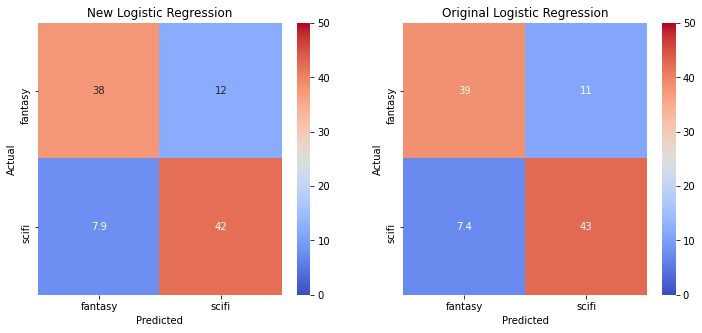

In [54]:

subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(12,5));

# New logistic regression after grid search, with max features = 5000:
ax = fig.add_subplot(121);
preds_new = lr2.predict(X2_test)
cm = confusion_matrix(y_test, preds_new)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('New Logistic Regression');

# original logistic regression:
ax = fig.add_subplot(122);
cm = confusion_matrix(y_test, preds_lr)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Original Logistic Regression');



This does not seem to be an improvement over the simple logistic regression with default parameters.

In [55]:
# make a dataframe of predictions from models run so far, along with actual subreddit classes:
predictions = pd.DataFrame(y_test)
predictions['Simple NB'] = preds_nb
predictions['Simple LR'] = preds_lr
predictions['LR 5000 features'] = preds_new
predictions

,types,Simple NB,Simple LR,LR 5000 features
468,fantasy,fantasy,fantasy,fantasy
5484,fantasy,fantasy,fantasy,fantasy
16900,scifi,scifi,scifi,scifi
19795,scifi,scifi,scifi,scifi
13019,scifi,scifi,scifi,scifi
...,...,...,...,...
15763,scifi,scifi,scifi,scifi
3959,fantasy,fantasy,fantasy,fantasy
11421,scifi,scifi,scifi,scifi
12414,scifi,fantasy,scifi,scifi


Make & save a dataframe with predictions (from X_test) for the three initial models, for future reference

Use 0 for fantasy and 1 for scifi.

In [56]:
predictions.to_csv('./data/predictions.csv')

In [57]:
label_dict = {'fantasy':0, 'scifi':1}
cols = ['types', 'Simple NB', 'Simple LR', 'LR 5000 features']
for col in cols:
    predictions[col].replace('fantasy',0, inplace=True)
    predictions[col].replace('scifi',1, inplace=True)

predictions


,types,Simple NB,Simple LR,LR 5000 features
468,0,0,0,0
5484,0,0,0,0
16900,1,1,1,1
19795,1,1,1,1
13019,1,1,1,1
...,...,...,...,...
15763,1,1,1,1
3959,0,0,0,0
11421,1,1,1,1
12414,1,0,1,1


Just as another measure of which model does the best, compare correlation to the actual y_test:

In [58]:
print('Correlation:')
pd.DataFrame(predictions.corr()['types'])

Correlation:


,types
types,1.000000
Simple NB,0.589259
Simple LR,0.631610
LR 5000 features,0.604153


The simple logistic regression model (default parameters) is the best so far.

In [59]:
probs_lr

array([[7.91807240e-01, 2.08192760e-01],
       [9.99999978e-01, 2.24208414e-08],
       [6.90303633e-02, 9.30969637e-01],
       ...,
       [2.51704270e-01, 7.48295730e-01],
       [7.32560866e-02, 9.26743913e-01],
       [9.99999989e-01, 1.09552184e-08]])

In [60]:
# make & save a new dataframe, probability, that includes the prediction, true value, 
# err type and label (TP, TN, FP, FN for scifi vs fantasy), and the probability 
# "scifi" according to the model.

probability1 = [prob[1] for prob in probs_lr]

probs = pd.DataFrame(y_test)
probs['prediction'] = preds_lr
probs['types'].replace('fantasy',0, inplace=True)
probs['types'].replace('scifi',1, inplace=True)
probs['prediction'].replace('fantasy',0, inplace=True)
probs['prediction'].replace('scifi',1, inplace=True)
probs['err type'] = probs['types'] + 2*probs['prediction']
probs['err label']= probs['err type']
probs['err label'].replace(0,'fantasy, correct',inplace=True)
probs['err label'].replace(1,'scifi->fantasy',inplace=True)
probs['err label'].replace(2,'fantasy->scifi',inplace=True)
probs['err label'].replace(3,'scifi, correct',inplace=True)
probs['probability'] = probability1
probs['err label'].value_counts()
probs.to_csv('./data/predicted_probabilities.csv')

In [61]:
probs.head()

,types,prediction,err type,err label,probability
468,0,0,0,"fantasy, correct",2.081928e-01
5484,0,0,0,"fantasy, correct",2.242084e-08
16900,1,1,3,"scifi, correct",9.309696e-01
19795,1,1,3,"scifi, correct",9.962833e-01
13019,1,1,3,"scifi, correct",7.649797e-01


In [62]:
probs.groupby('err label').mean()

,types,prediction,err type,probability
err label,,,,
"fantasy, correct",0,0,0,0.148220
fantasy->scifi,0,1,2,0.659380
"scifi, correct",1,1,3,0.816884
scifi->fantasy,1,0,1,0.318021


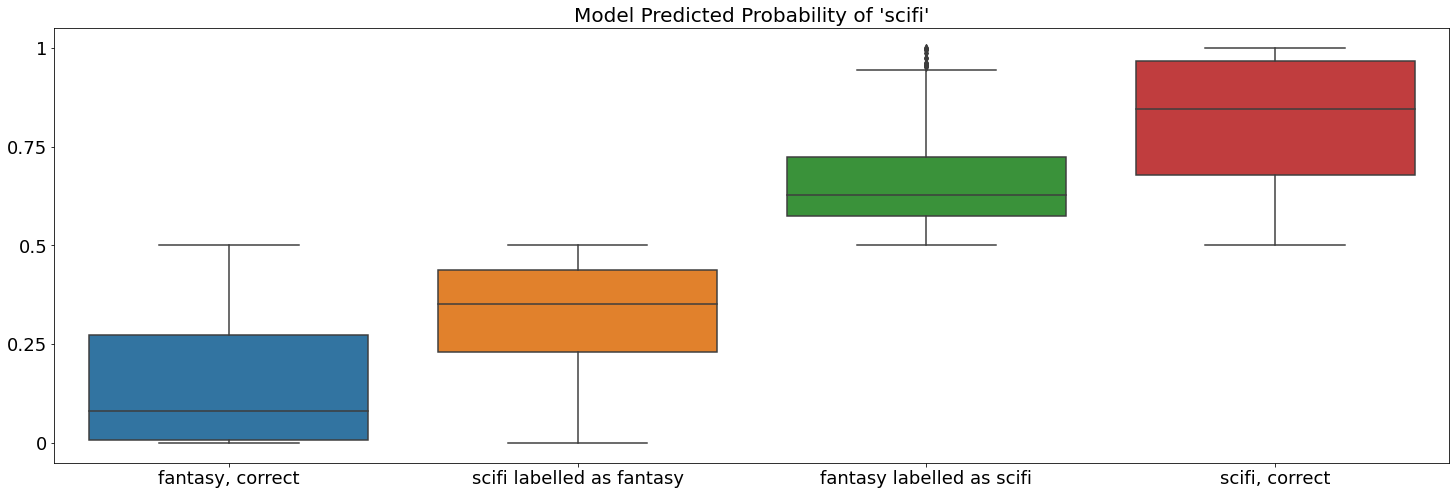

In [63]:
plt.figure(figsize=(25,8))
boxes = sns.boxplot(data=probs, x='err type', y='probability');
boxes.axes.set_title("Model Predicted Probability of 'scifi'",fontsize=20);
boxes.set_xlabel('');
boxes.set_ylabel('');
boxes.set_xticklabels(['fantasy, correct', 'scifi labelled as fantasy', 'fantasy labelled as scifi', 'scifi, correct'],fontsize=18);
boxes.set_yticks([0, 0.25, 0.5, 0.75, 1]);
boxes.set_yticklabels([0, 0.25, 0.5, 0.75, 1],fontsize=18);



This is more or less what I expected, but it confirms that the model's logic is basically sound:

* About 75% of the comments with probability less than 0.25 are correctly predicted as fantasy.
* About 75% of the comments with probability less than 0.5, but between 0.25 and 0.5, were mislabeled as fantasy.
* About 75% of the comments with probability more than 0.5, but between 0.5 and 0.75, were mislabeled as scifi.
* About 75% of the comments with probability more than 0.75 are correctly predicted as scifi.

When the model is more sure (prob < 0.25 or > 0.75), it is mostly correct. The ones it missed were mostly ones it was less sure about (prob closer to 0.5)

### Other notebooks:

* project3_3: I'll try to refine the logistic regression model.

* project3_4: KNN models.
  
* project3_5: Tfid instead of CountVectorizer, and experiments with stemming/lemmatizing.

* project3_6: Random Forest models.

* project3_7: Enough modeling, time to visualize.
